##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Generating Images with BigGAN


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/biggan_generation_with_tf_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/biggan_generation_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/biggan_generation_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/biggan_generation_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=deepmind%2Fbiggan"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook is a demo for the *BigGAN* image generators available on [TF Hub](https://tfhub.dev/s?publisher=deepmind&q=biggan).

See the [BigGAN paper on arXiv](https://arxiv.org/abs/1809.11096) [1] for more information about these models.

After connecting to a runtime, get started by following these instructions:

1. (Optional) Update the selected **`module_path`** in the first code cell below to load a BigGAN generator for a different image resolution.
2. Click **Runtime > Run all** to run each cell in order.
  * Afterwards, the interactive visualizations should update automatically when you modify the settings using the sliders and dropdown menus.
  * If not, press the **Play** button by the cell to re-render outputs manually.

Note: if you run into any issues, it can help to click **Runtime > Restart and run all...** to restart your runtime and rerun all cells from scratch.

[1] Andrew Brock, Jeff Donahue, and Karen Simonyan. [Large Scale GAN Training for High Fidelity Natural Image Synthesis](https://arxiv.org/abs/1809.11096). *arxiv:1809.11096*, 2018.

First, set the module path.
By default, we load the BigGAN-deep generator for 256x256 images from **`https://tfhub.dev/deepmind/biggan-deep-256/1`**.
To generate 128x128 or 512x512 images or to use the original BigGAN generators, comment out the active **`module_path`** setting and uncomment one of the others.

In [2]:
# BigGAN-deep models
# module_path = 'https://tfhub.dev/deepmind/biggan-deep-128/1'  # 128x128 BigGAN-deep
module_path = 'https://tfhub.dev/deepmind/biggan-deep-256/1'  # 256x256 BigGAN-deep
# module_path = 'https://tfhub.dev/deepmind/biggan-deep-512/1'  # 512x512 BigGAN-deep

# BigGAN (original) models
# module_path = 'https://tfhub.dev/deepmind/biggan-128/2'  # 128x128 BigGAN
# module_path = 'https://tfhub.dev/deepmind/biggan-256/2'  # 256x256 BigGAN
# module_path = 'https://tfhub.dev/deepmind/biggan-512/2'  # 512x512 BigGAN

## Setup

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import os
import io
import IPython.display
import numpy as np
import PIL.Image
from scipy.stats import truncnorm
import tensorflow_hub as hub


2023-11-07 12:59:55.358595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 12:59:55.358640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 12:59:55.360205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Instructions for updating:
non-resource variables are not supported in the long term


## Load a BigGAN generator module from TF Hub

In [4]:
tf.reset_default_graph()
print('Loading BigGAN module from:', module_path)
module = hub.Module(module_path)
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().items()}
output = module(inputs)

print()
print('Inputs:\n', '\n'.join(
    '  {}: {}'.format(*kv) for kv in inputs.items()))
print()
print('Output:', output)

Loading BigGAN module from: https://tfhub.dev/deepmind/biggan-deep-256/1


2023-11-07 13:00:18.684593: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore



Inputs:
   z: Tensor("z:0", shape=(?, 128), dtype=float32)
  truncation: Tensor("truncation:0", shape=(), dtype=float32)
  y: Tensor("y:0", shape=(?, 1000), dtype=float32)

Output: Tensor("module_apply_default/G_trunc_output:0", shape=(?, 256, 256, 3), dtype=float32)


## Define some functions for sampling and displaying BigGAN images

In [5]:
input_z = inputs['z']
input_y = inputs['y']
input_trunc = inputs['truncation']

dim_z = input_z.shape.as_list()[1]
vocab_size = input_y.shape.as_list()[1]

def truncated_z_sample(batch_size, truncation=1., seed=None):
  state = None if seed is None else np.random.RandomState(seed)
  values = truncnorm.rvs(-2, 2, size=(batch_size, dim_z), random_state=state)
  return truncation * values

def one_hot(index, vocab_size=vocab_size):
  index = np.asarray(index)
  if len(index.shape) == 0:
    index = np.asarray([index])
  assert len(index.shape) == 1
  num = index.shape[0]
  output = np.zeros((num, vocab_size), dtype=np.float32)
  output[np.arange(num), index] = 1
  return output

def one_hot_if_needed(label, vocab_size=vocab_size):
  label = np.asarray(label)
  if len(label.shape) <= 1:
    label = one_hot(label, vocab_size)
  assert len(label.shape) == 2
  return label

def sample(sess, noise, label, truncation=1., batch_size=8,
           vocab_size=vocab_size):
  noise = np.asarray(noise)
  label = np.asarray(label)
  num = noise.shape[0]
  if len(label.shape) == 0:
    label = np.asarray([label] * num)
  if label.shape[0] != num:
    raise ValueError('Got # noise samples ({}) != # label samples ({})'
                     .format(noise.shape[0], label.shape[0]))
  label = one_hot_if_needed(label, vocab_size)
  ims = []
  for batch_start in range(0, num, batch_size):
    s = slice(batch_start, min(num, batch_start + batch_size))
    feed_dict = {input_z: noise[s], input_y: label[s], input_trunc: truncation}
    ims.append(sess.run(output, feed_dict=feed_dict))
  ims = np.concatenate(ims, axis=0)
  assert ims.shape[0] == num
  ims = np.clip(((ims + 1) / 2.0) * 256, 0, 255)
  ims = np.uint8(ims)
  return ims

def interpolate(A, B, num_interps):
  if A.shape != B.shape:
    raise ValueError('A and B must have the same shape to interpolate.')
  alphas = np.linspace(0, 1, num_interps)
  return np.array([(1-a)*A + a*B for a in alphas])

def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = N // cols + int(N % cols != 0)
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(a).save(data, format)
  im_data = data.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print(('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format))
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

## Create a TensorFlow session and initialize variables

In [6]:
initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

# Explore BigGAN samples of a particular category

Try varying the **`truncation`** value.

(Double-click on the cell to view code.)

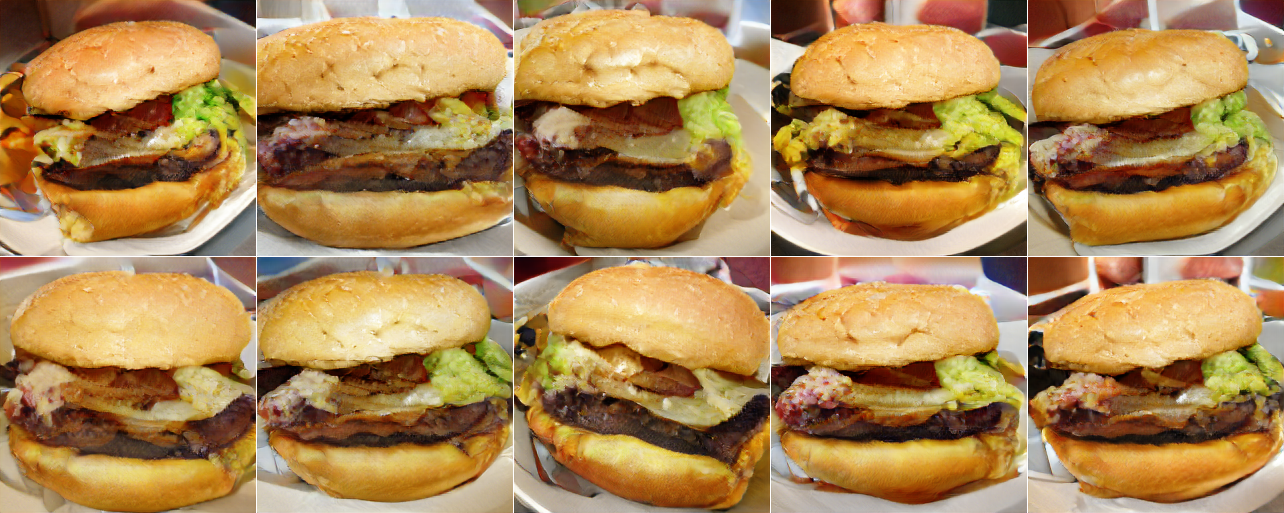

In [7]:
#@title Category-conditional sampling { display-mode: "form", run: "auto" }

num_samples = 10 #@param {type:"slider", min:1, max:20, step:1}
truncation = 0.4 #@param {type:"slider", min:0.02, max:1, step:0.02}
noise_seed = 0 #@param {type:"slider", min:0, max:100, step:1}
category = "933) cheeseburger"

z = truncated_z_sample(num_samples, truncation, noise_seed)
y = int(category.split(')')[0])

ims = sample(sess, z, y, truncation=truncation)
imshow(imgrid(ims, cols=min(num_samples, 5)))

# Interpolate between BigGAN samples

Try setting different **`category`**s  with the same **`noise_seed`**s, or the same **`category`**s with different **`noise_seed`**s. Or go wild and set both any way you like!

(Double-click on the cell to view code.)

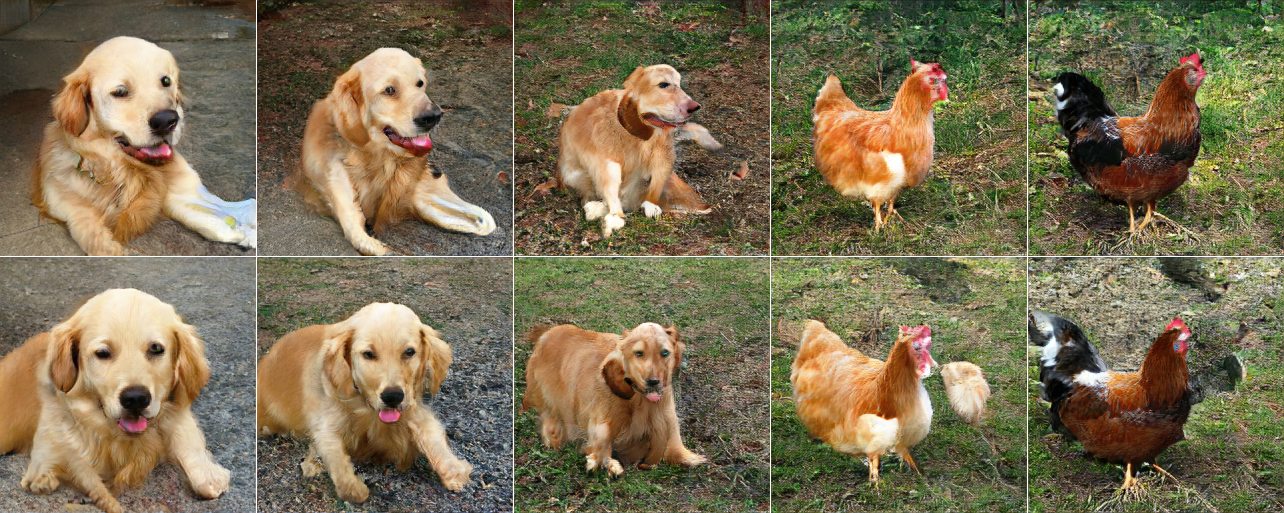

In [8]:
#@title Interpolation { display-mode: "form", run: "auto" }

num_samples = 2 #@param {type:"slider", min:1, max:5, step:1}
num_interps = 5 #@param {type:"slider", min:2, max:10, step:1}
truncation = 0.2 #@param {type:"slider", min:0.02, max:1, step:0.02}
noise_seed_A = 0 #@param {type:"slider", min:0, max:100, step:1}
category_A = "207) golden retriever"
noise_seed_B = 0 #@param {type:"slider", min:0, max:100, step:1}
category_B = "8) hen"

def interpolate_and_shape(A, B, num_interps):
  interps = interpolate(A, B, num_interps)
  return (interps.transpose(1, 0, *range(2, len(interps.shape)))
                 .reshape(num_samples * num_interps, *interps.shape[2:]))

z_A, z_B = [truncated_z_sample(num_samples, truncation, noise_seed)
            for noise_seed in [noise_seed_A, noise_seed_B]]
y_A, y_B = [one_hot([int(category.split(')')[0])] * num_samples)
            for category in [category_A, category_B]]

z_interp = interpolate_and_shape(z_A, z_B, num_interps)
y_interp = interpolate_and_shape(y_A, y_B, num_interps)

ims = sample(sess, z_interp, y_interp, truncation=truncation)
imshow(imgrid(ims, cols=num_interps))